In [ ]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-5gu2rp5x
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-5gu2rp5x
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440310 sha256=8727e49ec49a83f6dab2d9fdea8efb5ea400a74618785880617e887ddd914369
  Stored in directory: /tmp/pip-ephem-wheel-cache-exsmc91z/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf


In [ ]:
import os
import glob
import cv2
import imageio
import sys
import re

from __future__ import print_function

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

import skimage.io as io
import skimage.transform as trans

import tensorflow as tf

from tensorflow.python.keras.optimizers import TFOptimizer
from tensorflow.keras import backend as K
from keras.models import Model
from tensorflow import expand_dims
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.compat.v1 import image
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax
from tensorflow import math
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.nn import depth_to_space
from tensorflow.image import extract_patches
from tensorflow.keras.layers import Conv2D, Layer, Dense, Embedding, Dropout, Conv2D, LayerNormalization
from tensorflow.keras.activations import softmax
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jackezson","key":"3326ec98b566c1b2096d681037ec325b"}'}

In [ ]:
import os

# Make the Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into it
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!pip install kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prathamgrover/3d-liver-segmentation")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/3d-liver-segmentation


In [47]:
import shutil

# Create a directory in your Drive
drive_path = "/content/drive/MyDrive/liver_segmentation_dataset"
os.makedirs(drive_path, exist_ok=True)

# Copy files to your Drive
shutil.copytree(path, drive_path, dirs_exist_ok=True)

print("Dataset copied to Google Drive:", drive_path)


Dataset copied to Google Drive: /content/drive/MyDrive/liver_segmentation_dataset


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
import cv2
from skimage.measure import marching_cubes
!pip install numpy-stl
from stl import mesh

In [49]:
dataInputPath = '/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs'
imagePathInput = os.path.join(dataInputPath, 'imagesTr')
maskPathInput = os.path.join(dataInputPath, 'labelsTr')

dataOutputPath = '/content/drive/MyDrive/liver/'
imageSliceOutput = os.path.join(dataOutputPath, 'slice/img')
maskSliceOutput = os.path.join(dataOutputPath, 'slice/mask')

HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = False

SLICE_DECIMATE_IDENTIFIER = 3

In [50]:
imgPath = os.path.join(imagePathInput, 'liver_0.nii')
img = nib.load(imgPath).get_fdata()
np.min(img), np.max(img), img.shape, type(img)

(np.float64(-1024.0),
 np.float64(1343.04736328125),
 (180, 180, 125),
 numpy.memmap)

In [51]:
maskPath = os.path.join(maskPathInput, 'liver_0.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(np.float64(0.0), np.float64(2.0), (180, 180, 125), numpy.memmap)

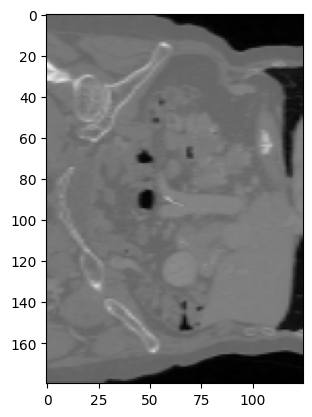

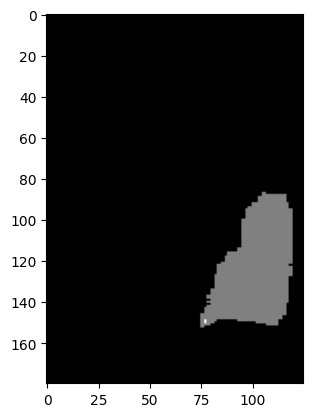

In [52]:
slice_num = 96
imgSlice = img[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = mask[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [53]:
def normalizeImage(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

nImg = normalizeImage(img.copy())
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(np.float64(0.0),
 np.float64(0.7810157877604167),
 (180, 180, 125),
 numpy.ndarray)

In [54]:
def normalizeMask(mask):
    return mask / 2.0

nMask = normalizeMask(mask.copy())
np.min(nMask), np.max(nMask), nMask.shape, type(nMask)

(np.float64(0.0), np.float64(1.0), (180, 180, 125), numpy.ndarray)

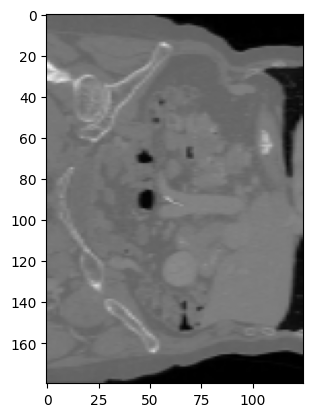

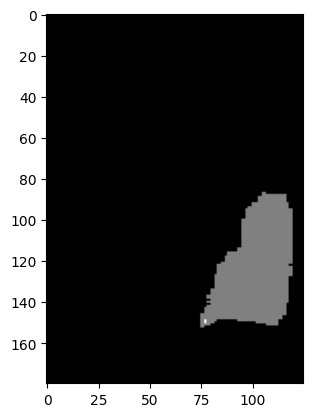

In [55]:
slice_num = 96
imgSlice = nImg[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = nMask[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [56]:
def readImageVolume(path, normalize=False):
    x = nib.load(path).get_fdata()
    if normalize:
        return normalizeImage(x)
    else:
        return normalizeMask(x)

In [57]:
def saveSlice(img, fname, path):
    if not os.path.exists(path):
        os.makedirs(path)
    img = np.uint8(img * 255)
    fout = os.path.join(path, f'{fname}.png')
    im = Image.fromarray(img)
    im.save(fout)
    print(f'[+] Slice saved: {fout}', end='\r')

In [58]:
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    if SLICE_X:
        cnt += dimx
        print('Slicing X: ')
        for i in range(dimx):
            saveSlice(vol[i,:,:], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_x', path)

    if SLICE_Y:
        cnt += dimy
        print('Slicing Y: ')
        for i in range(dimy):
            saveSlice(vol[:,i,:], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_y', path)

    if SLICE_Z:
        cnt += dimz
        print('Slicing Z: ')
        for i in range(dimz):
            saveSlice(vol[:,:,i], fname + f'-slice{str(i).zfill(SLICE_DECIMATE_IDENTIFIER)}_z', path)
    return cnt

In [59]:
x = 0
for index, filename in enumerate(sorted(glob.iglob(os.path.join(imagePathInput, '*.nii')))):
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.sum(img.shape), np.min(img), np.max(img))
    if x <= 10:
        p = os.path.join(imageSliceOutput, 'training')
    elif x <= 15:
        p = os.path.join(imageSliceOutput, 'test')
    else:
        break
    p = os.path.join(p, 'data')
    numOfSlices = sliceAndSaveVolumeImage(img, 'liver'+str(index), p)
    print(f'\n{filename}, {numOfSlices} slices created \n')
    x += 1

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_0.nii (180, 180, 125) 485 0.0 0.7810157877604167
180 180 125
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/img/training/data/liver0-slice179_y.png
/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_0.nii, 360 slices created 

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_1.nii (173, 173, 205) 551 0.0 1.0
173 173 205
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/img/training/data/liver1-slice172_y.png
/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_1.nii, 346 slices created 

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_10.nii (197, 197, 167) 561 0.0 0.8593886311848958
197 197 167
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/img/training/data/liver2-slice196_y.png
/content/drive/MyDrive

In [60]:
x = 0
for index, filename in enumerate(sorted(glob.iglob(os.path.join(maskPathInput, '*.nii')))):
    mask = readImageVolume(filename, False)
    print(filename, mask.shape, np.sum(mask.shape), np.min(mask), np.max(mask))
    if x <= 10:
        p = os.path.join(maskSliceOutput, 'training')
    elif x <= 15:
        p = os.path.join(maskSliceOutput, 'test')
    else:
        break
    p = os.path.join(p, 'data')
    numOfSlices = sliceAndSaveVolumeImage(mask, 'liver'+str(index), p)
    print(f'\n{filename}, {numOfSlices} slices created \n')
    x += 1

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_0.nii (180, 180, 125) 485 0.0 1.0
180 180 125
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/mask/training/data/liver0-slice179_y.png
/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_0.nii, 360 slices created 

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_1.nii (173, 173, 205) 551 0.0 1.0
173 173 205
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/mask/training/data/liver1-slice172_y.png
/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_1.nii, 346 slices created 

/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_10.nii (197, 197, 167) 561 0.0 1.0
197 197 167
Slicing X: 
Slicing Y: 
[+] Slice saved: /content/drive/MyDrive/liver/slice/mask/training/data/liver2-slice196_y.png
/content/drive/MyDrive/liver_segmentation_dataset

In [74]:
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir_train_image = '/content/drive/MyDrive/liver/slice/img/training'
data_dir_train_mask = '/content/drive/MyDrive/liver/slice/mask/training'

data_dir_test_image = '/content/drive/MyDrive/liver/slice/img/test'
data_dir_test_mask = '/content/drive/MyDrive/liver/slice/mask/test'

NUM_OF_EPOCHS = 10

In [75]:
def create_segmentation_generator(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)

    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, msk_generator)

In [76]:
train_generator = create_segmentation_generator(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)

Found 4204 images belonging to 1 classes.
Found 4204 images belonging to 1 classes.


In [77]:
test_generator = create_segmentation_generator(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 1844 images belonging to 1 classes.
Found 1844 images belonging to 1 classes.


In [78]:
NUM_TRAIN = 4204
NUM_TEST = 1844

In [79]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [80]:
def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

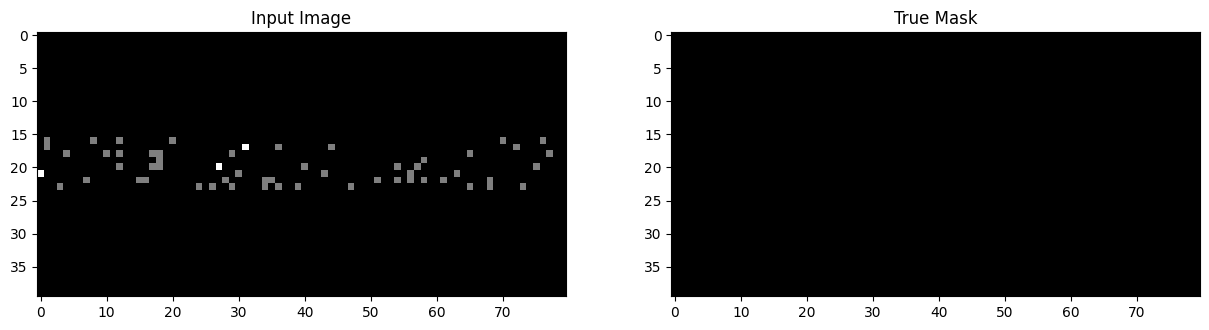

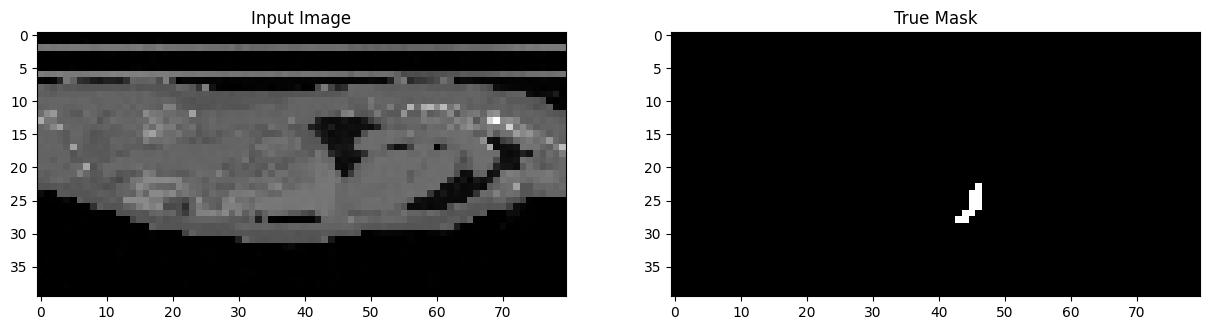

In [68]:
show_dataset(train_generator, 2)

In [82]:
def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs

    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')

    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)

    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)

    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)

    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [83]:
EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
model.summary()

Model: "UNET-L4-F32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 40, 80,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 40, 80,    │      9,248 │ conv2d_53[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 20, 40,    │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 20, 40,    │     18,496 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 20, 40,    │     36,928 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 10, 20,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 10, 20,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 10, 20,    │    147,584 │ conv2d_57[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 5, 10,     │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 5, 10,     │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 5, 10,     │    590,080 │ conv2d_59[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 10, 20,    │    295,040 │ conv2d_60[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 10, 20,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 10, 20,    │    295,040 │ concatenate_11[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 10, 20,    │    147,584 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 20, 40,    │     73,792 │ conv2d_62[0][0] 

 Total params: 2,140,065 (8.16 MB)

 Trainable params: 2,140,065 (8.16 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
def fit_gen(datagen):
    while True:
        img_batch, msk_batch = next(datagen)
        yield img_batch, msk_batch

In [87]:
model.fit(fit_gen(train_generator),
          steps_per_epoch=EPOCH_STEP_TRAIN,
          validation_data=fit_gen(test_generator),
          validation_steps=EPOCH_STEP_TEST,
          epochs=NUM_OF_EPOCHS)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - accuracy: 0.9791 - loss: 0.0170 - val_accuracy: 0.9784 - val_loss: 0.0236
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.9802 - loss: 0.0161 - val_accuracy: 0.9798 - val_loss: 0.0236
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - accuracy: 0.9792 - loss: 0.0188 - val_accuracy: 0.9794 - val_loss: 0.0231
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.9799 - loss: 0.0163 - val_accuracy: 0.9793 - val_loss: 0.0291
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.9795 - loss: 0.0161 - val_accuracy: 0.9794 - val_loss: 0.0321
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 334ms/step - accuracy: 0.9802 - loss: 0.0154 - val_accuracy: 0.9801 - val_loss: 0.0354
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 261ms/step - accuracy: 0.9801 - loss: 0.0152 - val_accuracy: 0.9788 - val_loss: 0.0306
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 288ms/step - accuracy: 0.9805 - loss: 0

In [88]:
model.save(os.path.join(dataOutputPath, f'UNET-LiverSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}.h5'))

In [89]:
targetImagePath = '/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/imagesTr/liver_127.nii'
targetMaskPath  = '/content/drive/MyDrive/liver_segmentation_dataset/Task03_Liver_rs/labelsTr/liver_127.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImage(imgTargetNii.get_fdata())
imgMask = normalizeMask(imgMaskNii.get_fdata())

In [90]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [91]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape

    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))

    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)

    outImg = (outImgX + outImgY + outImgZ)/cnt
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [92]:
predImg = predictVolume(imgTarget)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_89']
Received: inputs=Tensor(shape=(1, 40, 80, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

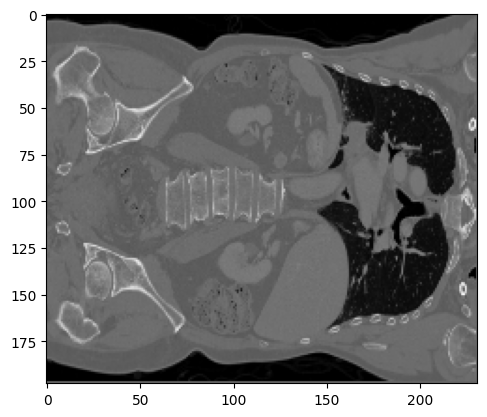

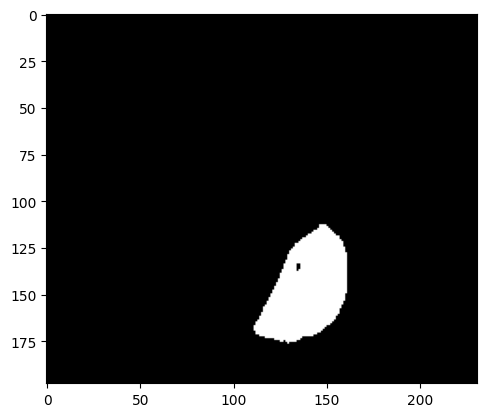

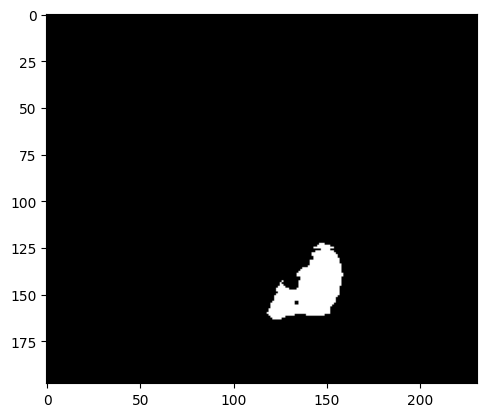

In [93]:
slice_num = 96
imgSlice = imgTarget[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = imgMask[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = predImg[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

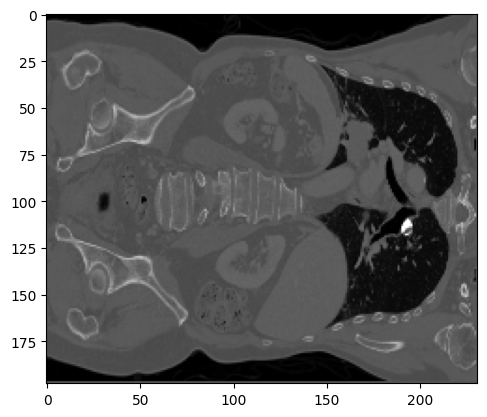

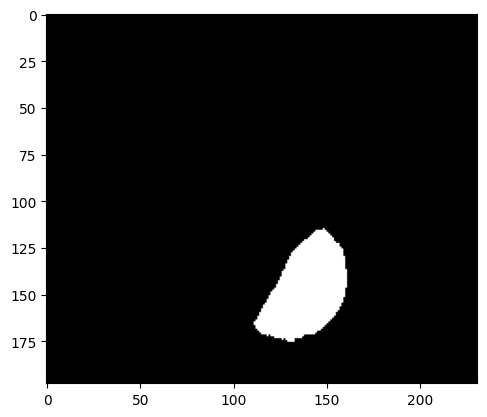

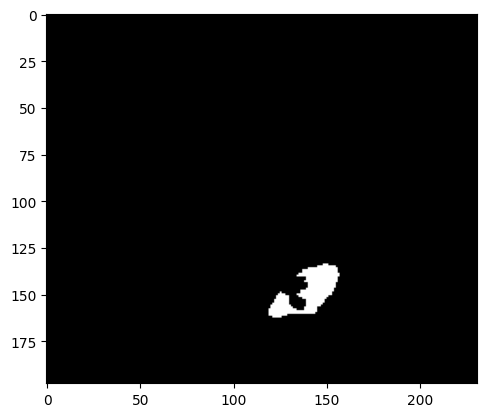

In [95]:
slice_num = 92
imgSlice = imgTarget[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = imgMask[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

imgSlice = predImg[:,slice_num,:]
plt.imshow(imgSlice, cmap='gray')
plt.show()

In [96]:
vertices,faces,_,_ = marching_cubes(predImg)

In [97]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = vert[f[j],:]
    return mm

In [98]:
mm = dataToMesh(vertices, faces)
mm.save('liver-segmented.stl')

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure  # For contour detection


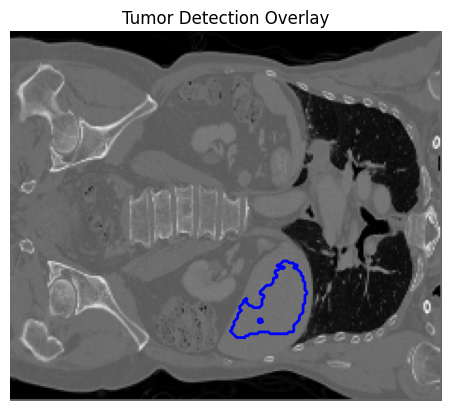

In [100]:
slice_num = 96

# Get the target (original) slice
img_slice = imgTarget[:, slice_num, :]

# Get the predicted mask slice (binary)
pred_slice = predImg[:, slice_num, :]

# Plot original image
fig, ax = plt.subplots()
ax.imshow(img_slice, cmap='gray')

# Find contours in the predicted mask
contours = measure.find_contours(pred_slice, level=0.5)

# Plot contours on top
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')

ax.set_title("Tumor Detection Overlay")
plt.axis("off")
plt.show()


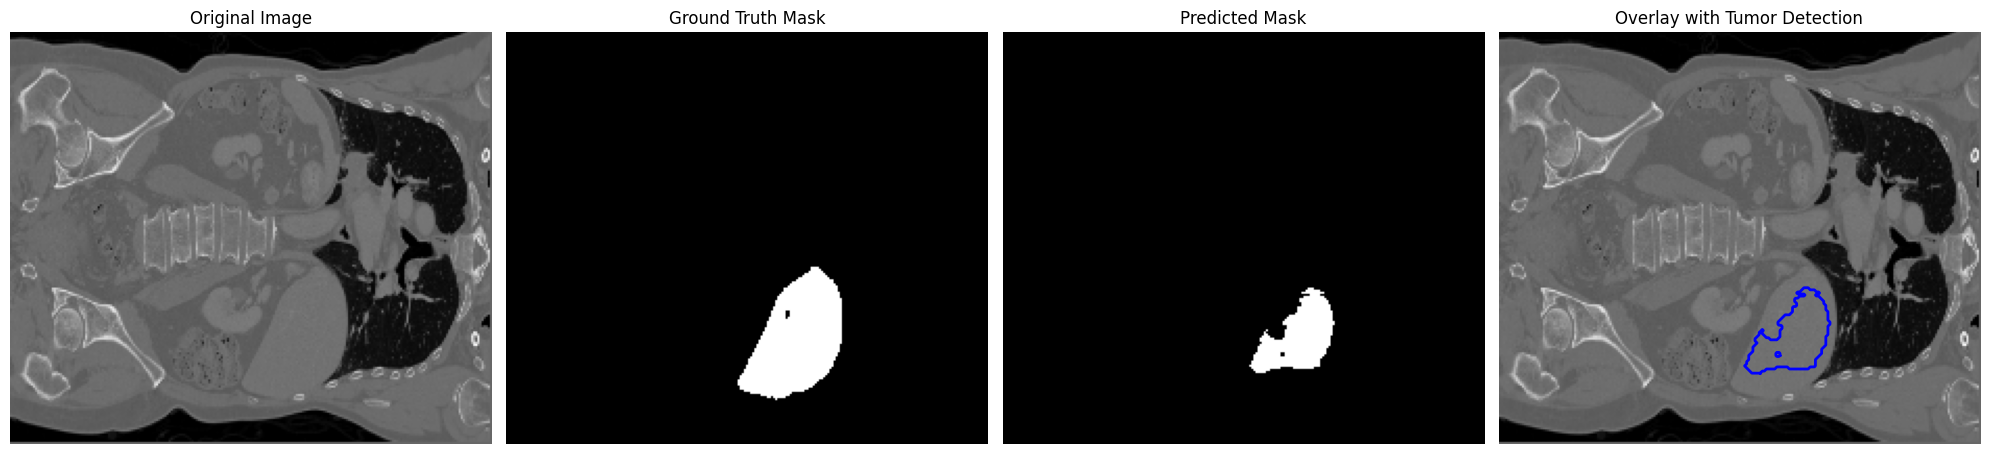

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Select slice number
slice_num = 96

# Extract slices
orig_slice = imgTarget[:, slice_num, :]
mask_slice = imgMask[:, slice_num, :]
pred_slice = predImg[:, slice_num, :]

# Create subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Original Image
axes[0].imshow(orig_slice, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# 2. Ground Truth Mask
axes[1].imshow(mask_slice, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# 3. Predicted Mask
axes[2].imshow(pred_slice, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# 4. Overlay: Original + Prediction Outline
axes[3].imshow(orig_slice, cmap='gray')
contours = measure.find_contours(pred_slice, 0.5)
for contour in contours:
    axes[3].plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
axes[3].set_title("Overlay with Tumor Detection")
axes[3].axis("off")

plt.tight_layout()
plt.show()


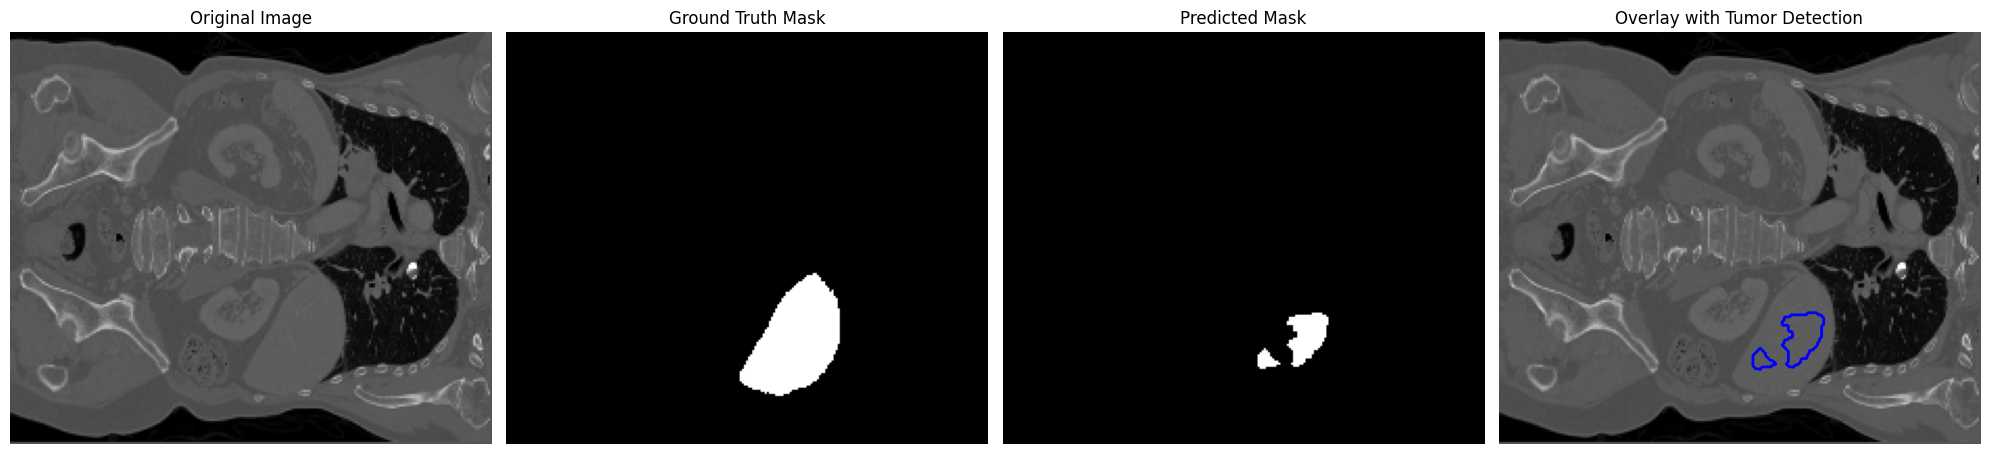

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# Select slice number
slice_num = 90

# Extract slices
orig_slice = imgTarget[:, slice_num, :]
mask_slice = imgMask[:, slice_num, :]
pred_slice = predImg[:, slice_num, :]

# Create subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 1. Original Image
axes[0].imshow(orig_slice, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# 2. Ground Truth Mask
axes[1].imshow(mask_slice, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

# 3. Predicted Mask
axes[2].imshow(pred_slice, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis("off")

# 4. Overlay: Original + Prediction Outline
axes[3].imshow(orig_slice, cmap='gray')
contours = measure.find_contours(pred_slice, 0.5)
for contour in contours:
    axes[3].plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')
axes[3].set_title("Overlay with Tumor Detection")
axes[3].axis("off")

plt.tight_layout()
plt.show()